# 理解 RNN

**<font color='red'>前馈网络 (feedforward network)</font>** (如，FCNN 和 convnet) 没有记忆。它们单独处理每个输入，在输入与输入之间没有保存任何状态。对于这样的网络，要想处理数据点的序列或时间序列，你需要向网络同时展示整个序列，即将序列转换成单个数据点。


**<font color='red'>循环神经网络 (RNN，recurrent neural network)</font>** 处理序列的方式是，遍历所有序列元素，并保存一个状态 (state)，其中包含与已查看内容相关的信息。

实际上，RNN 是一类具有内部环的神经网络。在处理两个不同的独立序列 (比如两条不同的 IMDB 评论) 之间，RNN 状态会被重置，因此，你仍可以将一个序列看作单个数据点，即网络的单个输入。真正改变的是，数据点不再是在单个步骤中进行处理，相反，网络内部会对序列元素进行遍历。

![rnn](figs/chap06-figs/rnn.png)

<font color='crimson'>RNN 对时间步 (timestep) 进行遍历，在每个时间步，它考虑 t 时刻的当前状态与 t 时刻的输入 [形状为 `(input_ features,)`]，对二者计算得到 t 时刻的输出。然后，我们将下一个时间步的状态设置为上一个时间步的输出。</font>对于第一个时间步，上一个时间步的输出没有定义，所以它没有当前状态。因此，你需要将状态初始化为一个全零向量，这叫作网络的初始状态(initial state)。

In [1]:
# Common imports
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

np.random.seed(42)
tf.random.set_seed(42)

os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [2]:
tf.__version__

'2.0.0'

## 1. SimpleRNN

In [3]:
# 简单 RNN 的 NumPy 实现
timesteps = 100       # 输入序列的时间步
input_features = 32   # 输入特征空间的维度
output_features = 64  # 输出特征空间的维度

inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))  # 初始状态为 0

# 随机初始化权重
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []
# 遍历 timesteps
for input_t in inputs:  # shape: (input_features, ) 
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)  # 当前输出
    successive_outputs.append(output_t)
    state_t = output_t  # 更新 state，用于下一个 timestep

final_output_sequence = np.stack(successive_outputs, axis=0)
final_output_sequence.shape  # (timesteps, output_features)

(100, 64)

总之，RNN 是一个 for 循环，它重复使用循环前一次迭代的计算结果。

RNN 的特征在于其时间步函数：`output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)`。

![simple RNN](figs/chap06-figs/simple_rnn.png)
<center>一个简单的 RNN，随时间展开</center>

<div class="alert alert-block alert-info">
    <b>最终输出是一个形状为 (timesteps, output_features) 的二维张量，其中每个时间步是循环在 t 时刻的输出。输出张量中的每个时间步 t 包含输入序列中时间步 0~t 的信息，即关于全部过去的信息。因此，在多数情况下，并不需要这个所有输出组成的序列，只需要最后一个输出 (循环结束时的 output_t)，因为它已经包含了整个序列的信息。</b>
</div>

上面的代码对应于 `tf.keras.layers.SimpleRNN`。

**`SimpleRNN` 层能够像其他 Keras 层一样处理序列批量**，而不是像 NumPy 示例那样只能处理单个序列。因此，它**接收形状为 `(batch_size, timesteps, input_features)` 的输入**，而不是 `(timesteps, input_features)`。

**<font color='crimson'>SimpleRNN 可以在 2 种不同的模式下运行：</font>**

- <font color='crimson'>返回每个 timestep 连续输出的完整序列，即形状为 `(batch_size, timesteps, output_features)` 的三维张量</font>


- <font color='crimson'>只返回每个输入序列的最终输出，即形状为 `(batch_size, output_features)` 的二维张量</font>

<font color='crimson'>这 2 种模式由参数 `return_sequences` 控制。</font>

In [4]:
inputs = np.random.random([32, 10, 8]).astype(np.float32)
# 返回每个 timestep 连续输出的完整序列
simple_rnn = tf.keras.layers.SimpleRNN(4, return_sequences=True)

output = simple_rnn(inputs)
output.shape  # shape [32, 10, 4]

TensorShape([32, 10, 4])

In [5]:
inputs = np.random.random([32, 10, 8]).astype(np.float32)
# Return the last output in the output sequence
simple_rnn = tf.keras.layers.SimpleRNN(4)

output = simple_rnn(inputs)
output.shape  # shape [32, 4]

TensorShape([32, 4])

In [6]:
# 只返回最后一个 timestep 的输出
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 32),
    # Fully-connected RNN where the output is to be fed back to input.
    tf.keras.layers.SimpleRNN(32,  # dimensionality of the output space.
                              # Activation function to use
                              # Default `'tanh'`
                              # Ff pass `None`, no activation is applied, a(x)=x
                              activation='tanh'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Return the last output in the output sequence
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 32),
    # Fully-connected RNN where the output is to be fed back to input.
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


**<font color='crimson'>为了提高网络的表示能力，将多个 RNN 逐个堆叠有时也是很有用的。在这种情况下，需要让所有中间层都返回完整的输出序列。</font>**

In [8]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 32),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    # 最后一层仅返回最后一个 timestep 的输出
    tf.keras.layers.SimpleRNN(32), 
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


> `2080 = 32*32 + 32*32 + 32`

In [9]:
# Load and process the IMDB data
max_features = 10000
maxlen = 500
batch_size = 32

print('Loading data ...')
(input_train, y_train), (input_test, y_test) = tf.keras.datasets.imdb.load_data(
    num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('\nPad sequences ...')
x_train = tf.keras.preprocessing.sequence.pad_sequences(input_train)
x_test = tf.keras.preprocessing.sequence.pad_sequences(input_test)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data ...
25000 train sequences
25000 test sequences

Pad sequences ...
x_train shape: (25000, 2494)
x_test shape: (25000, 2315)


In [10]:
# Train a RNN model on IMDB data
tf.keras.backend.clear_session()

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features, 32))
model.add(tf.keras.layers.SimpleRNN(32))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=1,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
20000/20000 [==============================] - 306s 15ms/sample - loss: 0.6272 - acc: 0.6018 - val_loss: 0.4842 - val_acc: 0.7808


**`tf.keras.layers.SimpleRNN` 好像不能用 GPU 加速！**

如果跑完，<font color='crimson'>模型的精度并不高，问题的部分原因在于输入只考虑了前 500 个单词，而不是整个序列。另一部分原因在于，`SimpleRNN` 不擅长处理长序列，比如文本。</font>

## 2. LSTM and GRU

<font color='blue'>SimpleRNN 通常过于简化，没有实用价值。</font>

<font color='crimson'>SimpleRNN 的最大问题是，在时刻 t，理论上来说，它应该能够记住许多时间步之前见过的信息，但实际上它是不可能学到这种长期依赖的。其原因在于梯度消失问题 (vanishing gradient problem)，这一效应类似于在层数较多的非循环网络 (即前馈网络) 中观察到的效应：随着层数的增加，网络最终变得无法训练。</font>

<font color='blue'>LSTM (long short-term memory) 层和 GRU (Gated Recurrent Unit) 层都是为了解决梯度消失问题而设计的。</font>

<font color='crimson'>LSTM 层是 SimpleRNN 层的一种变体，它增加了一种携带信息跨越多个时间步的方法。</font> 假设有一条传送带，其运行方向平行于你所处理的序列。序列中的信息可以在任意位置跳上传送带，然后被传送到更晚的时间步，并在需要时原封不动地跳回来。这实际上就是 **<font color='crimson'>LSTM 的原理：它保存信息以便后面使用，从而防止较早期的信号在处理过程中逐渐消失</font>**。

<font color='blue'>LSTM 中“输入门”、“遗忘门”和“输出门”其实没有多大意义，因为这些运算的实际效果是由参数化权重决定的，而权重是以端到端的方式进行学习，每次训练都要从头开始，不可能为某个运算赋予特定的目的。RNN 单元的类型决定了你的假设空间，即在训练期间搜索良好模型配置的空间，但它不能决定 RNN 单元的作用，那是由单元权重来决定的。同一个单元具有不同的权重，可以实现完全不同的作用。因此，组成 RNN 单元的运算组合，最好被解释为对搜索的一组约束，而不是一种工程意义上的设计。</font>

对于研究人员来说，这种约束的选择(即如何实现 RNN 单元)似乎最好是留给最优化算法来完成(比如遗传算法或强化学习过程)，而不是让人类工程师来完成。

**<font color='crimson'>总之，你不需要理解关于 LSTM 单元具体架构的任何内容。作为人类，理解它不应该是你要做的。你只需要记住 LSTM 单元的作用：允许过去的信息稍后重新进入，从而解决梯度消失问题。</font>**

In [11]:
# Train a LSTM model on IMDB data
tf.keras.backend.clear_session()

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features, 32))
model.add(tf.keras.layers.LSTM(32))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 32s 2ms/sample - loss: 0.5213 - acc: 0.7179 - val_loss: 0.3595 - val_acc: 0.8416
Epoch 2/10
20000/20000 [==============================] - 27s 1ms/sample - loss: 0.3195 - acc: 0.8696 - val_loss: 0.3017 - val_acc: 0.8706
Epoch 3/10
20000/20000 [==============================] - 27s 1ms/sample - loss: 0.2427 - acc: 0.9067 - val_loss: 0.3211 - val_acc: 0.8610
Epoch 4/10
20000/20000 [==============================] - 27s 1ms/sample - loss: 0.2089 - acc: 0.9212 - val_loss: 0.3260 - val_acc: 0.8408
Epoch 5/10
20000/20000 [==============================] - 28s 1ms/sample - loss: 0.1830 - acc: 0.9325 - val_loss: 0.2999 - val_acc: 0.8918
Epoch 6/10
20000/20000 [==============================] - 27s 1ms/sample - loss: 0.1624 - acc: 0.9412 - val_loss: 0.3171 - val_acc: 0.8834
Epoch 7/10
20000/20000 [==============================] - 28s 1ms/sample - loss: 0.1502 - acc: 0.9471 - val_loss: 0.3

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [13]:
def plot_history(history):
    history_dict = history.history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']

    epochs = [i + 1 for i in history.epoch]

    # Plot the results
    plt.figure(figsize=(14, 4.2))
    plt.subplot(121)
    plt.plot(epochs, loss_values, 'c+-', label='Training loss')
    plt.plot(epochs, val_loss_values, 'm.-', label='Val loss')
    plt.xlabel('Epochs', fontsize=12)
    plt.xticks(epochs, rotation=90)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=18)
    plt.title('Training and validation loss', fontsize=16)

    plt.subplot(122)
    plt.plot(epochs, acc, 'c+-', label='Training acc')
    plt.plot(epochs, val_acc, 'm.-', label='Val acc')
    plt.xlabel('Epochs', fontsize=12)
    plt.xticks(epochs, rotation=90)
    plt.ylabel('Acc', fontsize=12)
    plt.legend(fontsize=18)
    plt.title('Training and validation acc', fontsize=16)

    plt.show()

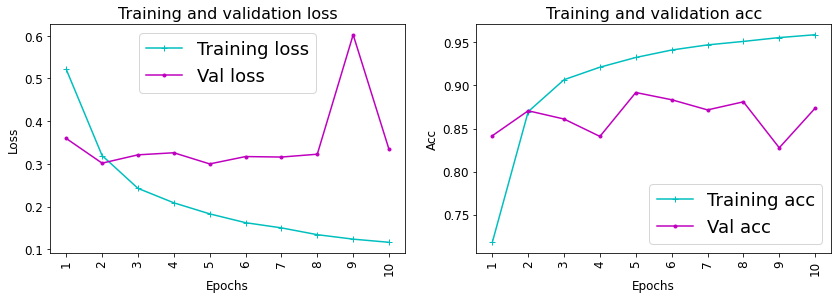

In [14]:
plot_history(history)

比 `SimpleRNN` 效果要好，这主要因为 LSTM 受梯度消失问题的影响要小很多。但结果没有非常好，一个原因是没有耗费时间来调参，另一个原因可能是缺少正则化。但主要原因是，<font color='crimson'>分析评论的全局、长期性结构（LSTM 所擅长的），对情感分析问题帮助不大。对于这样的问题，观察每条评论中出现了哪些词及其出现频率就可以很好地解决。</font>这也正是第一个全连接方法的做法。但还有更加困难的 nlp 问题，特别是问答和机器翻译，这时 LSTM 的优势就明显了。

But honestly, the primary reason is that analyzing the global, long-term structure of the reviews (what LSTM is good at) isn’t helpful for a sentiment-analysis problem. Such a basic problem is well solved by looking at what words occur in each review, and at what frequency. 